<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Exercise 2.X - And now, for our feature presentation...</h1>
<h2 align="center"> Extracting features from a continuous movie stimulus to build a model</h2> 
<h2 align="center">Summer Workshop on the Dynamic Brain</h2> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

In the workshops of the day and other exercises we looked at the responses of neurons to brief visual stimuli (250ms flashes). Unless you are at club with with an intense strobe light, this is far from the usual visual experience. Visual scenes have movement and evolve continuously. The visual coding and visual behavior datasets include repeated presentations of 30 second clips from a movie (Touch of Evil, 1958, Orson Welles) to achieve a more natural visual input. 

This type of stimulus contains much more rich information than static presentations. Each frame may have different image statistics and types of objects. There is relationship between the contents of each frame. 

**How do we extract meaningful information from continuous stimuli to build a model that includes information the visual system may care about?**

In this exercise we will:
1) Get neural activity related to movie stimulus
2) Use an approach called feature engineering to extract meaningful information from the movie
3) Build a model to predict single cell activity from the movie features.


For more information about the movie, see here:
+ https://observatory.brain-map.org/visualcoding/stimulus/natural_movies
+ https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html#behavioral-training

In [27]:
# import basics 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.signal as signal
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# import allensdk 
import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
allensdk.__version__

# import utilities to reformat neural activity data
import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting
import brain_observatory_utilities.utilities.general_utilities as general_utilities

# import scikit-learn functions for the model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [8]:
# Find some data!
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"
    data_roo = r"/swdb2024_data_cache"

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**1) Get the movie and a dataset**

First lets load the movie

In [10]:
movie_path = r"/allen/programs/braintv/workgroups/neuralcoding/Saskia/Visual Stimuli 151207/Movie_TOE1.npy"
movie = np.load(movie_path)
print(f"Movie shape: {movie.shape}")

Movie shape: (900, 304, 608)


Plot every 100 frames of the movie

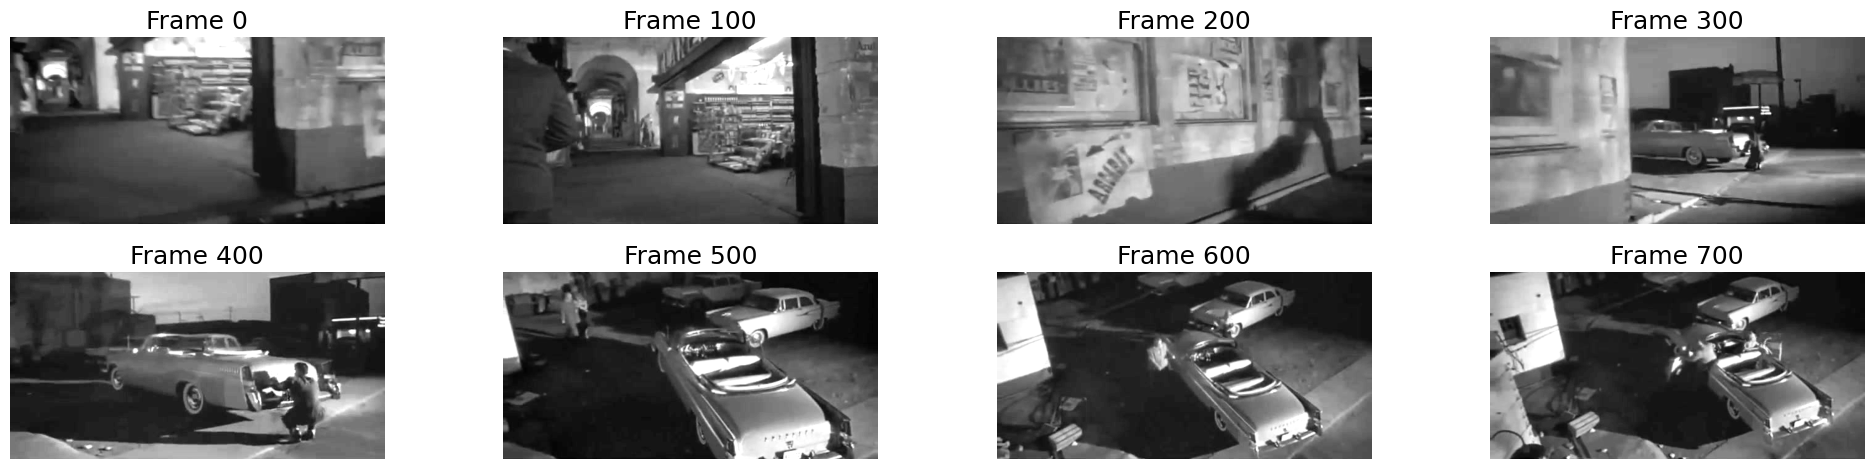

In [11]:
fig, ax = plt.subplots(2,4,figsize=(20, 5))
ax = ax.ravel()
for i in range(8):
    ax[i].imshow(movie[100*i], cmap='gray')
    ax[i].set_title(f"Frame {100*i}")
    ax[i].axis('off')
plt.tight_layout()

Get some neural data from the visual behavior dataset

In [15]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

output_dir = r'/swdb2024_data_cache'
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=output_dir)

behavior_session_table = cache.get_behavior_session_table()  
ophys_session_table = cache.get_ophys_session_table()   
ophys_experiment_table = cache.get_ophys_experiment_table()    
ophys_cells_table = cache.get_ophys_cells_table()

project_code = 'VisualBehaviorMultiscope'
multiscope_sessions = ophys_session_table[ophys_session_table.project_code==project_code]

print(f"Number of mice: {len(multiscope_sessions.mouse_id.unique())}")
print(multiscope_sessions.full_genotype.unique())

# pick a mouse + a sessions from visual behavior that have movie stimulus at the end
mouse_id = '546605' # SST
sessions = ophys_session_table[(ophys_session_table.mouse_id==mouse_id) & 
                                (ophys_session_table.session_type=='OPHYS_1_images_A')]

# get the dataset for an experiment
ophys_experiment_id = 1080945462
dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id)

# pick a cell
cell_specimen_id = 1120091421

Number of mice: 24
['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'
 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt']
['initial_gray_screen_5min' 'change_detection_behavior'
 'post_behavior_gray_screen_5min' 'natural_movie_one']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**1) Getting movie related neural activity**

# get the stimulus table
stimulus_presentations = dataset.stimulus_presentations.copy()
print(stimulus_presentations.stimulus_block_name.unique())

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(1a) Get movie related stimulus blocks from stimulus_presentations**

+ Make new table, movie_presentations, with just "natural_movie_one" stimuli.
+ How many movie_repeats are there? 
+ How many frames in one repeat of the movie?


In [16]:
stimulus_presentations = dataset.stimulus_presentations.copy()
movie_presentations = stimulus_presentations[stimulus_presentations.stimulus_block_name=='natural_movie_one']
movie_presentations

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,is_sham_change,active,stimulus_name
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
4808,3,natural_movie_one,-99,NaN,0,0.03336,4217.392861,4217.426221,252272,252273,False,<NA>,<NA>,0,7,-99,False,False,natural_movie_one
4809,3,natural_movie_one,-99,NaN,1,0.03333,4217.426221,4217.459551,252274,252275,False,<NA>,<NA>,0,8,-99,False,False,natural_movie_one
4810,3,natural_movie_one,-99,NaN,2,0.03337,4217.459551,4217.492921,252276,252277,False,<NA>,<NA>,0,9,-99,False,False,natural_movie_one
4811,3,natural_movie_one,-99,NaN,3,0.03336,4217.492921,4217.526281,252278,252279,False,<NA>,<NA>,0,10,-99,False,False,natural_movie_one
4812,3,natural_movie_one,-99,NaN,4,0.03336,4217.526281,4217.559641,252280,252281,False,<NA>,<NA>,0,11,-99,False,False,natural_movie_one
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13803,3,natural_movie_one,-99,NaN,895,0.03336,4517.471281,4517.504641,270262,270263,False,<NA>,<NA>,9,9002,-99,False,False,natural_movie_one
13804,3,natural_movie_one,-99,NaN,896,0.03336,4517.504641,4517.538001,270264,270265,False,<NA>,<NA>,9,9003,-99,False,False,natural_movie_one
13805,3,natural_movie_one,-99,NaN,897,0.03335,4517.538001,4517.571351,270266,270267,False,<NA>,<NA>,9,9004,-99,False,False,natural_movie_one


In [19]:
print(movie_presentations.movie_repeat.unique())

[0 1 2 3 4 5 6 7 8 9]


In [111]:
repeat_0 = movie_presentations[movie_presentations.movie_repeat==0]
print(f"Number of frames: {len(repeat_0)}")

Number of frames: 900


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**Optional:** calculate the frame rate of the movie from the 'duration' columns


In [112]:
repeat_0.duration

stimulus_presentations_id
4808    0.03336
4809    0.03333
4810    0.03337
4811    0.03336
4812    0.03336
         ...   
5703    0.03335
5704    0.03337
5705    0.03336
5706    0.03335
5707    0.03338
Name: duration, Length: 900, dtype: float64

In [113]:
rate = 1/ repeat_0.duration.iloc[0]
print(f"Frame rate: {rate}")

Frame rate: 29.9760191843314


So we have around 30hz x 900 frames = 30 second movie

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(1b) Get the start times of each movie**

In [29]:
movie_starts = movie_presentations[movie_presentations.movie_frame_index==0]
movie_starts

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,is_sham_change,active,stimulus_name
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
4808,3,natural_movie_one,-99,NaN,0,0.03336,4217.392861,4217.426221,252272,252273,False,<NA>,<NA>,0,7,-99,False,False,natural_movie_one
5708,3,natural_movie_one,-99,NaN,0,0.03336,4247.417371,4247.450731,254072,254073,False,<NA>,<NA>,1,907,-99,False,False,natural_movie_one
6608,3,natural_movie_one,-99,NaN,0,0.03334,4277.441891,4277.475231,255872,255873,False,<NA>,<NA>,2,1807,-99,False,False,natural_movie_one
7508,3,natural_movie_one,-99,NaN,0,0.03336,4307.466411,4307.499771,257672,257673,False,<NA>,<NA>,3,2707,-99,False,False,natural_movie_one
8408,3,natural_movie_one,-99,NaN,0,0.03331,4337.490981,4337.524291,259472,259473,False,<NA>,<NA>,4,3607,-99,False,False,natural_movie_one
9308,3,natural_movie_one,-99,NaN,0,0.03336,4367.515471,4367.548831,261272,261273,False,<NA>,<NA>,5,4507,-99,False,False,natural_movie_one
10208,3,natural_movie_one,-99,NaN,0,0.03335,4397.539981,4397.573331,263072,263073,False,<NA>,<NA>,6,5407,-99,False,False,natural_movie_one
11108,3,natural_movie_one,-99,NaN,0,0.03336,4427.564511,4427.597871,264872,264873,False,<NA>,<NA>,7,6307,-99,False,False,natural_movie_one
12008,3,natural_movie_one,-99,NaN,0,0.03337,4457.589021,4457.622391,266672,266673,False,<NA>,<NA>,8,7207,-99,False,False,natural_movie_one


In [32]:
event_times = movie_starts.start_time.values

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(1c) Get neural activity aligned to movie start times**

Use:
+ `brain_observatory_utilities.datasets.optical_physiology.data_formatting.build_tidy_cell_df` to format neural data in convient way
+ `brain_observatory_utilities.utilities.general_utilities.event_triggered_response` to align any list of event_times/start_times with neural data
+ Note: you can study how get_stimulus_response_df() calls the more specific function event_triggered_response(), but don't spend too much time on this step. The particulars can be
found in the solutions notebook.


In [24]:
data = data_formatting.build_tidy_cell_df(dataset, exclude_invalid_rois=True)
unique_ids = np.unique(data['cell_specimen_id'].values)
print(f"The cells in dataset are: {unique_ids}")

The cells in dataset are: [1120091374 1120091421 1120091574 1120091628 1120091659]


In [33]:
output_sampling_rate = 30 # hz
time_window = [0, 30] # large time window to capture the whole movie
interpolate = True
data_type = 'dff'

# collect aligned data
sliced_dataout = []

# align data using interpolation method
for unique_id in unique_ids:
    etr = general_utilities.event_triggered_response(
        data=data[data['cell_specimen_id'] == unique_id],
        t='timestamps',
        y=data_type,
        event_times=event_times,
        t_start=time_window[0],
        t_end=time_window[1],
        output_format='wide',
        interpolate=interpolate,
        output_sampling_rate=output_sampling_rate
    )

    # get timestamps array
    trace_timebase = etr.index.values

    # collect aligned data from all cell, all trials into one array
    sliced_dataout.append(etr.transpose().values)
sliced_dataout = np.array(sliced_dataout)

# remove the last element of the timebase array and the last element of the data array
trace_timebase = trace_timebase[:-1]
sliced_dataout = sliced_dataout[:, :, :-1]

print(sliced_dataout.shape)

(5, 10, 900)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(1d) Plot the activity of each repeat for one cell. Plot the mean across repeats**

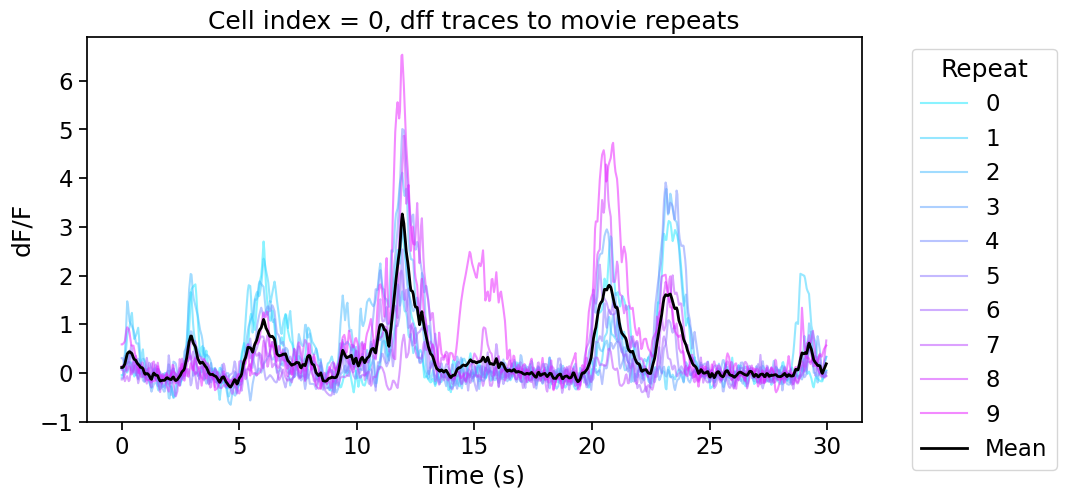

In [122]:
# plot traces for a single cell
cell_index = 0

cell_traces = sliced_dataout[cell_index]
colors = sns.color_palette('cool', n_colors=cell_traces.shape[0])
plt.figure(figsize=(10, 5))
for i in range(cell_traces.shape[0]):
    plt.plot(trace_timebase, cell_traces[i], color=colors[i], alpha=0.5, label=i)
plt.title(f'Cell index = {cell_index}, dff traces to movie repeats')
plt.xlabel('Time (s)')
plt.ylabel('dF/F')

# plot mean
mean_trace = np.mean(cell_traces, axis=0)
plt.plot(trace_timebase, mean_trace, color='black', linewidth=2, label='Mean')
plt.legend(title='Repeat', bbox_to_anchor=(1.05, 1), loc='upper left')


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(1e) Plot the mean response (to all repeats) of each cell**

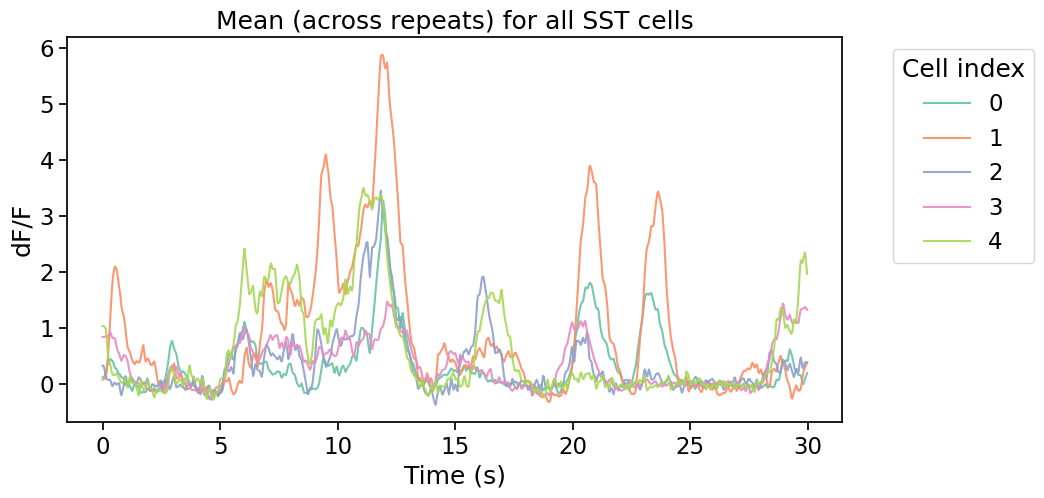

In [124]:
# get mean response for each cell
cell_mean_traces = np.mean(sliced_dataout, axis=1)
cell_mean_traces.shape

# plot mean traces for all cells
plt.figure(figsize=(10, 5))
colors = sns.color_palette('Set2', n_colors=sliced_dataout.shape[0])

for i in range(cell_mean_traces.shape[0]):
    plt.plot(trace_timebase, cell_mean_traces[i], color=colors[i], alpha=0.9, label=i)
plt.xlabel('Time (s)')
plt.ylabel('dF/F')
# legend for cells
plt.legend(range(sliced_dataout.shape[0]))
plt.title('Mean (across repeats) for all SST cells')

plt.legend(title='Cell index', bbox_to_anchor=(1.05, 1), loc='upper left')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**2) Extract features from the movie**

Here we extract a set of movie features to use in our model. The following paper used a similar approach,
so lets take inspiration from the authors for which features to extract.

Froudarakis 2014 "Population code in mouse V1 facilitates readout of 
natural scenes through increased sparseness".

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(2a) Calculate metrics for each movie frame**


For each frame calculate:
1) Average pixel intensity
2) Kurtosis of pixel intensities
3) Contrast (standard deviation) of pixel intensities
4) Motion energy between frames (how much the movie changes frame to frame); a higher number indicates more "motion" between frames

In [40]:
# function to calculate the "motion energy" between frames
def calc_motion_energy(movie: np.array) -> np.array:
    """
    Calculate motion energy between frames,
    defined as the sum of absolute differences between frames

    Parameters
    ----------
    movie : np.array
        The movie to calculate motion energy for

    Returns
    -------
    motion_energy : np.array
        The motion energy between
    """
    # calculate motion energy
    motion_energy = np.zeros(movie.shape[0]-1)
    for i in range(movie.shape[0]-1):
        motion_energy[i] = np.sum(np.abs(movie[i+1] - movie[i]))

    # add zero to the end
    motion_energy = np.append(motion_energy, 0)
    return motion_energy

In [41]:
# calculate motion energy between frames
def calc_movie_metrics(movie):
    """Calculate motion energy, average, contrast, and kurtosis for a movie"""

    # calculate motion energy
    motion_energy = calc_motion_energy(movie)
    avg = np.mean(movie, axis=(1,2)) #
    contrast = np.std(movie, axis=(1,2))
    kurtosis = stats.kurtosis(movie, axis=(1,2))

    return motion_energy, avg, contrast, kurtosis

motion_energy, avg, contrast, kurtosis = calc_movie_metrics(movie)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(2b) Filter motion energy and plot**
Plot the motion energy, notice something strange? It dips near zero every few frames, because nearly identical frames appear every so often. This is do to some resampling strategy used to generate the movie stimulus.
Is it fair to assume the mouse visual system would not detect the identical frames? For this exercise lets assume yes, and smooth out the motion energy.

Use scipy.signal.medfilt to smooth the motion energy

Text(0, 0.5, 'Motion energy')

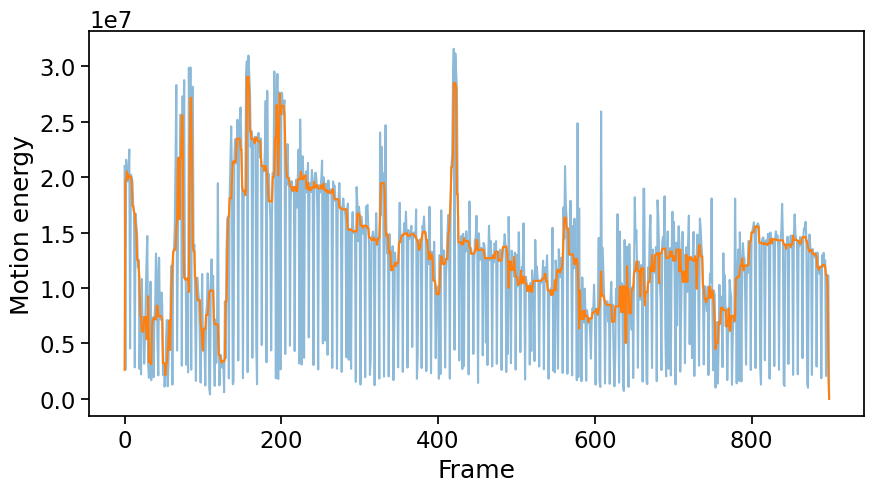

In [42]:
motion_energy_filtered = signal.medfilt(motion_energy, kernel_size=7)

plt.figure(figsize=(10, 5))
plt.plot(motion_energy,label='Motion energy', alpha=0.5)
plt.plot(motion_energy_filtered, label='Motion energy (filtered)')
plt.xlabel('Frame')
plt.ylabel('Motion energy')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(2c) Plot all 4 features on subplots. Add the mean response for a single cell.**

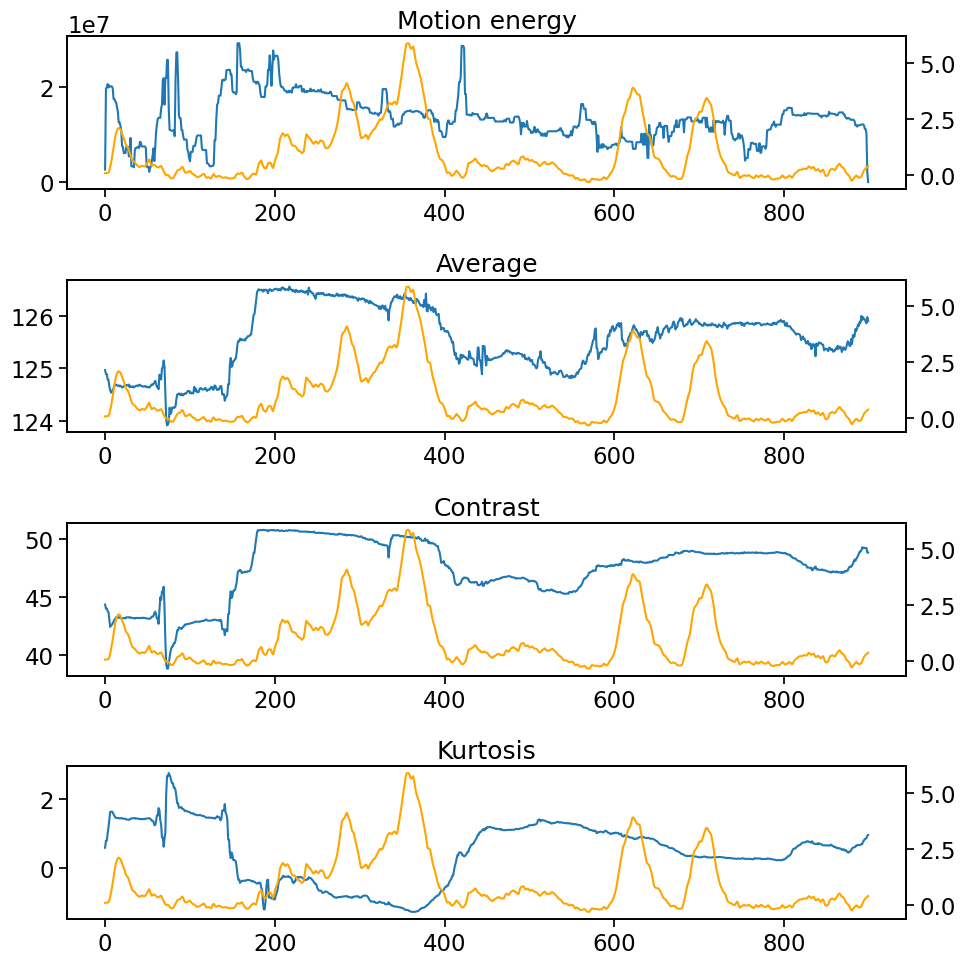

In [21]:
cell_index = 1
cell_trace_to_plot = cell_mean_traces[cell_index]

x_axis_time = np.arange(0, len(cell_trace_to_plot))
#x_axis_time = trace_timebase

fig, axes = plt.subplots(4,1,figsize=(10, 10))
axes = axes.ravel()

axes[0].plot(x_axis_time, motion_energy_filtered, label='Motion energy')
axes[0].set_title('Motion energy')

axes[1].plot(x_axis_time, avg, label='Average')
axes[1].set_title('Average')

axes[2].plot(x_axis_time, contrast, label='Contrast')
axes[2].set_title('Contrast')

axes[3].plot(x_axis_time, kurtosis, label='Kurtosis')
axes[3].set_title('Kurtosis')

for ax in axes:
    ax2 = ax.twinx()
    ax2.plot(x_axis_time, cell_trace_to_plot, label='Cell trace', color='orange')

# xlim
plt.tight_layout()


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**3) Build a linear model uses extracted features**

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(3a) Create stimulus matrix X with 4 features. Use MinMaxScaler() to normalize.**

In [47]:
X = np.vstack([motion_energy_filtered, avg, contrast, kurtosis]).T
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Text(0.5, 1.0, 'Scaled movie features')

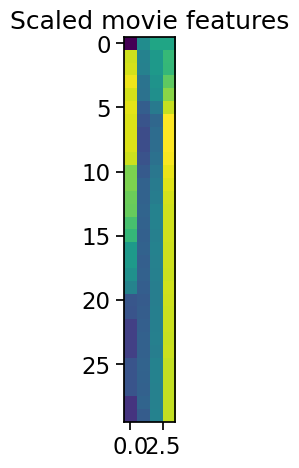

In [48]:
fig, ax = plt.subplots(1,figsize=(5, 5))
plt.imshow(X[:30])
plt.title('Scaled movie features')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**(3a) Try a linear model using stimulus features X to predict neural response y**
+ We have 10 repeats of the movie presented, and the neural response to each repeat.
+ To train the model using all the repeats, we just need to alter the shapes inputs X and Y.
+ We can stack the response of one cell to each repeat into a long vector, and use that as the response vector Y.
+ We need to duplicate the X stimlus matrix to match the (use np.tile)
Use LeaveOneOut() crossvalidation

In [52]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

In [50]:
# first select all the repeats for a single cell
cell_index = 0
cell_dff_repeats = sliced_dataout[cell_index]
print(cell_dff_repeats.shape)

(10, 900)


In [68]:
movie_features = X

loo = LeaveOneOut()
predictions = []
actuals = []
models = []
coefficients = []
intercepts = []

for train_index, test_index in loo.split(cell_dff_repeats):
    # Split the data
    X_train = np.tile(movie_features, (len(train_index), 1))
    y_train = cell_dff_repeats[train_index].flatten()
    X_test = movie_features
    y_test = cell_dff_repeats[test_index].flatten()
    print(f"Train: {X_train.shape}, {y_train.shape}. Test: {X_test.shape}, {y_test.shape}")
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Collect coefficients and intercepts
    coefficients.append(model.coef_)
    intercepts.append(model.intercept_)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Store predictions and actuals
    predictions.append(y_pred)
    actuals.append(y_test)

# Convert lists to arrays
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

# Evaluate model performance
mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error: {mse}")

Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Mean Squared Error: 0.5393062633287183


shape: (900,), (900,)
Mean Squared Error of Averaged Model: 0.5547199717435338
Averaged Coefficients: [-0.55083098  0.9628919  -0.87636595 -1.03820669]
Averaged Intercept: 1.0543079993077653


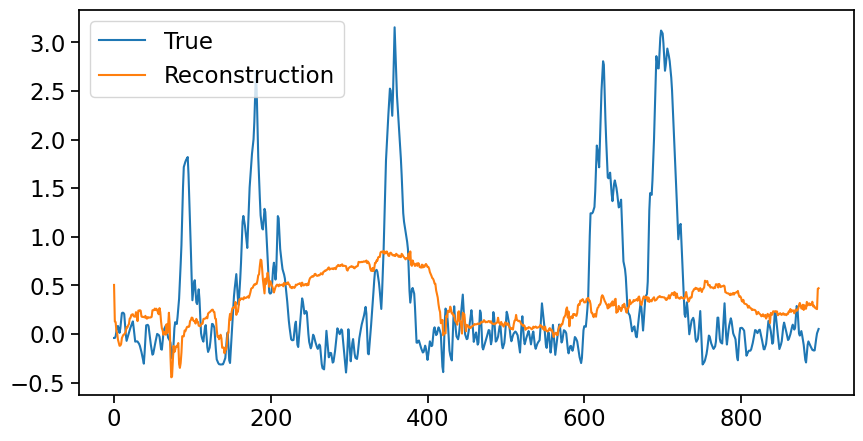

In [69]:
avg_coefficients = np.mean(coefficients, axis=0)
avg_intercept = np.mean(intercepts, axis=0)

average_model = LinearRegression()
average_model.coef_ = avg_coefficients
average_model.intercept_ = avg_intercept

# select 1 repeat
y_all = cell_dff_repeats[0]
X_all = movie_features
y_pred = average_model.predict(X_all)
print(f"shape: {y_all.shape}, {y_pred.shape}")

# Evaluate model performance
mse = mean_squared_error(y_all, y_pred)
print(f"Mean Squared Error of Averaged Model: {mse}")

# Optional: Print the averaged coefficients and intercept
print(f"Averaged Coefficients: {avg_coefficients}")
print(f"Averaged Intercept: {avg_intercept}")

# plot reconstruction
reconstruction = y_pred
score = average_model.score(X_all, y_all)

plt.figure(figsize=(10, 5))
plt.plot(y_all, label='True')
plt.plot(reconstruction, label='Reconstruction')
plt.legend()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**Bonus) use polynomial features in linear model to improve predections**

In [62]:
from sklearn.preprocessing import PolynomialFeatures

In [63]:
degree = 2 # select a 

movie_features = X
poly = PolynomialFeatures(degree)
movie_features_poly = poly.fit_transform(movie_features)

loo = LeaveOneOut()
predictions = []
actuals = []
models = []
coefficients = []
intercepts = []

for train_index, test_index in loo.split(cell_dff_repeats):
    # Split the data
    X_train = np.tile(movie_features_poly, (len(train_index), 1))
    y_train = cell_dff_repeats[train_index].flatten()
    X_test = movie_features_poly
    y_test = cell_dff_repeats[test_index].flatten()
    print(f"Train: {X_train.shape}, {y_train.shape}. Test: {X_test.shape}, {y_test.shape}")
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Collect coefficients and intercepts
    coefficients.append(model.coef_)
    intercepts.append(model.intercept_)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Store predictions and actuals
    predictions.append(y_pred)
    actuals.append(y_test)

# Convert lists to arrays
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

# Evaluate model performance
mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error: {mse}")

Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Train: (8100, 15), (8100,). Test: (900, 15), (900,)
Mean Squared Error: 0.499438402601332


shape: (900,), (900,)
Mean Squared Error of Averaged Model: 0.6271265868146201
Averaged Coefficients: [  0.           1.22736973  -4.29022835 -15.65021893 -27.50215158
  -0.63003802  -2.61795385   1.77285422  -0.97005185 -17.74679384
  36.93632437   2.37629155 -10.17343428  18.66549945  16.11675085]
Averaged Intercept: 11.94810181047274


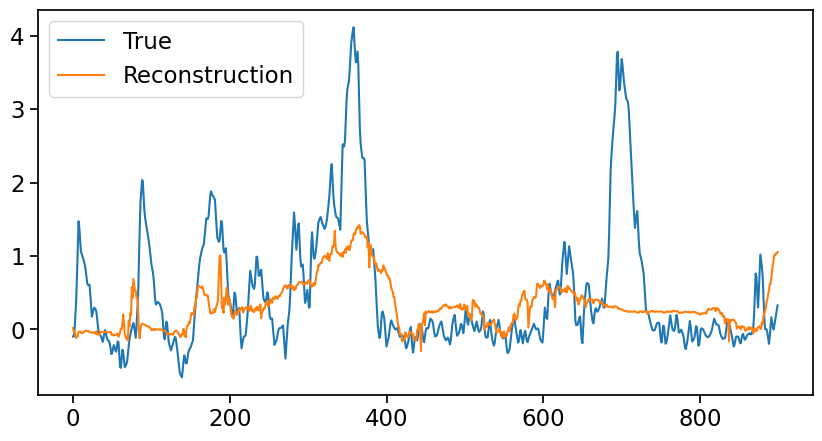

In [65]:
avg_coefficients = np.mean(coefficients, axis=0)
avg_intercept = np.mean(intercepts, axis=0)

average_model = LinearRegression()
average_model.coef_ = avg_coefficients
average_model.intercept_ = avg_intercept

# select 1 repeat
y_all = cell_dff_repeats[2]
X_all = movie_features_poly
y_pred = average_model.predict(X_all)
print(f"shape: {y_all.shape}, {y_pred.shape}")

# Evaluate model performance
mse = mean_squared_error(y_all, y_pred)
print(f"Mean Squared Error of Averaged Model: {mse}")

# Optional: Print the averaged coefficients and intercept
print(f"Averaged Coefficients: {avg_coefficients}")
print(f"Averaged Intercept: {avg_intercept}")

# plot reconstruction
reconstruction_poly = y_pred
score = average_model.score(X_all, y_all)

plt.figure(figsize=(10, 5))
plt.plot(y_all, label='True')
plt.plot(reconstruction_poly, label='Reconstruction')
plt.legend()

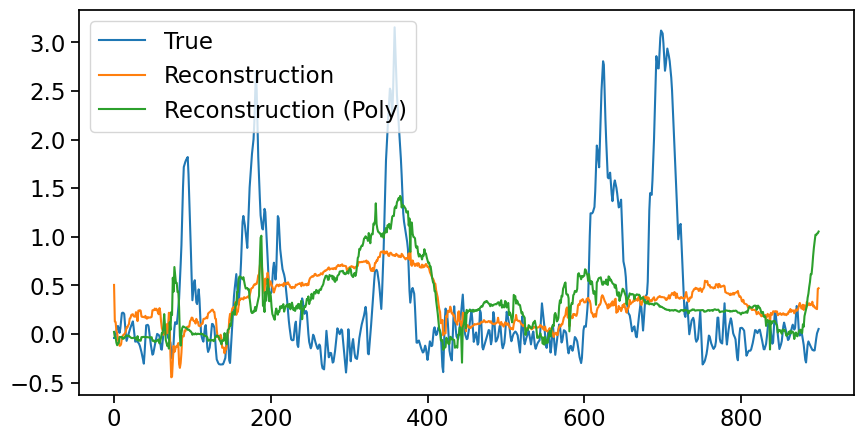

In [70]:
# plot reconstruction and reconstruction_poly and true

plt.figure(figsize=(10, 5))
plt.plot(y_all, label='True')
plt.plot(reconstruction, label='Reconstruction')
plt.plot(reconstruction_poly, label='Reconstruction (Poly)')
plt.legend()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

**Bonus: Does cropping the movie lead to better model?**

In [238]:
# get shape of movie frame
movie.shape

(900, 304, 608)

In [83]:
# crop 100 pixel box around center
crop_size = 100
center = movie.shape[1] // 2
movie_cropped = movie[:, center-crop_size:center+crop_size, center-crop_size:center+crop_size]
movie_cropped.shape


(900, 200, 200)

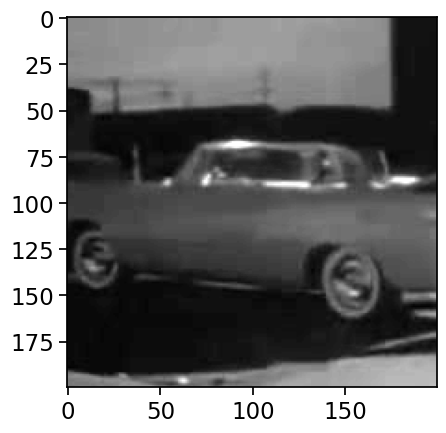

In [84]:
# plot frame of cropped movie
plt.imshow(movie_cropped[350], cmap='gray')

In [94]:
# calc metrics for cropped movie
motion_energy_crop, avg_crop, contrast_crop, kurtosis_crop = calc_movie_metrics(movie_cropped)
me_filtered_crop = signal.medfilt(motion_energy_crop, kernel_size=7)

X_crop = np.vstack([me_filtered_crop, avg_crop, contrast_crop, kurtosis_crop]).T

# us min max scaler to build X
scaler = MinMaxScaler()
X_crop = scaler.fit_transform(X)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

This exercise was intended to introduce the movie stimulus, practice getting neural activity aligned to any stimulus start_time, and extracting features to do some modeling. We built a simple model using LeaveOneOut crossvalidation. This is just the start, what else can we discover using the movie stimulus?
+ More sophisticated features extraction methods (e.g. neural networks)
+ Non linear modeling
+ Different cell types (VIP, SST, PV, excitatory). Perhaps others or more/less sensitive to movies?
+ How can one incorporate information about a neurons receptive fields?